# Miniproyecto 3 / ModSim

    - Rodrigo Zea
    - Sebastian Arriola

In [1]:
import numpy as np
import math
import random
import matplotlib.pyplot as plt

### Seed para generador de númerosa aleatorios uniformes

In [60]:
random.seed(69)

## Generadores de Números Aleatorios

In [61]:
def poisson(lam=1):
    return -((1.0 / lam) * np.log(random.random()))
        
def exponential(lam=1):
    return -((1.0 / lam) * np.log(random.random()))

## Variables Globales de Simulacion

In [62]:
# amount of servers rented at Ants
SERVERS = 10
# Max requests per minute and second
MAX_REQ_PER_MIN = 2400
MAX_REQ_PER_SEC = MAX_REQ_PER_MIN / 60
# Gorilla computation power, 100 requests per second
GORILLA_REQ_PER_SEC = 100
GORILLA_SEC_PER_REQ = 1 / GORILLA_REQ_PER_SEC
# Ants computation power, 10 requests per second
ANTS_REQ_PER_SEC = 10
ANTS_SEC_PER_REQ = 1 / ANTS_REQ_PER_SEC

# simulation time
T = 3600

## Simulación para 1 Servidor (Gorilla)

In [63]:
def g_server_simulation(offline_time=3600):
    # Offline time
    T = 3600
    na = 0
    nd = 0
    n = 0
    t = 0
    # Generate T0

    # initial time of next customer arrival
    ta = poisson(lam=MAX_REQ_PER_SEC)
    # current time is set to next arrival
    #t = ta

    td = math.inf

    # for output data, keep track of arrival times and departures of customers
    arrivals, departures = {}, {}
    ytot = []

    while t <= T or n > 0:
        if (ta <= td and ta <= T):
            t = ta
            na += 1
            n += 1
            # Generate Tt
            ta = t + poisson(lam=MAX_REQ_PER_SEC)
            if (n == 1):
                # generar y
                Y = exponential(lam=GORILLA_REQ_PER_SEC)
                # generate y and update sig exit
                td = t + Y
                
            # store arrival time of customer  
            arrivals[na] = t
            ytot.append(Y)
        elif (td < ta and td <= T):
            t = td
            n -= 1
            nd += 1

            if (n == 0):
                td = math.inf
            else:
                # generar y
                Y = exponential(lam=GORILLA_REQ_PER_SEC)
                # generate y and update sig exit
                td = t + Y
            # store departure time of customer
            departures[nd] = t
            ytot.append(Y)
        elif (min(ta, td) > T and n > 0):
            t = td
            n -= 1
            nd += 1

            if (n > 0):
                # generar y
                Y = exponential(lam=GORILLA_REQ_PER_SEC)
                # generate y and update sig exit
                td = t + Y   
            # store departure time of customer
            departures[nd] = t
            ytot.append(Y)
        elif (min(ta, td) > T and n == 0):
            tp = max(t - T, 0)
            break

    print('Simulation finished...')
    return (
        t,
        na, 
        nd, 
        arrivals, 
        departures,
        ytot)

In [64]:
(t, na, nd, arrivals, departures, ytot) = g_server_simulation()

Simulation finished...


In [65]:
# Some calcs to display results later
busy = sum(ytot)/3600
idle = 3600-sum(ytot)

diff = min(len(arrivals), len(departures))


dep = list(departures.values())
arri = list(arrivals.values())

times = [(dep[i]-arri[i]) for i in range(diff)]
avgTime = sum(times)/diff

avgProcs = len(departures)/3600

In [66]:
print("""
------------------------------------------------------------------
                     ANALISIS DE RESULTADOS
------------------------------------------------------------------
""")
print("Momento de la ultima salida: " + str(list(departures.values())[-1]))
print("Numero de procesos atendidos: " + str(nd))
print("Tiempo procesando: " + str(busy))
print("Tiempo idle: " + str(idle))
print("Tiempo total de los procesos en cola: " + str(sum(ytot)))
print("Tiempo promedio de un proceso en cola: " + str(avgTime))
print("Numero promedio de procesos en cola: " + str(avgProcs))


------------------------------------------------------------------
                     ANALISIS DE RESULTADOS
------------------------------------------------------------------

Momento de la ultima salida: 3600.015840713297
Numero de procesos atendidos: 143558
Tiempo procesando: 0.888630837014642
Tiempo idle: 400.92898674728895
Tiempo total de los procesos en cola: 3199.071013252711
Tiempo promedio de un proceso en cola: 0.01658221538693729
Numero promedio de procesos en cola: 39.87722222222222


## Simulación para N Servidores

In [67]:
def n_server_simulation(n_servers=1, offline_time=3600):
    # Offline Time
    T = offline_time
    # System State
    n = 0
    # arrivals and departures by time t
    na, nd = 0, 0

    # number of customers served by servers
    customers_attended_per_server = [0 for _ in range(n_servers)]
    # holds customer id currently being attended for each server of 0 if server is idle
    current_server_state = [0 for _ in range(n_servers)]

    # time past T when last customer departs
    tp = 0

    # initial time of next customer departure
    next_departures = [math.inf for _ in range(n_servers)]

    # initial time of next customer arrival
    ta = poisson(lam=MAX_REQ_PER_SEC)
    # current time is set to next arrival
    t = ta

    # for output data, keep track of arrival times and departures of customers
    arrivals, departures = {}, {}
    # keep track of server busy time
    servers_busy_time = [0 for _ in range(n_servers)]
    # to keep track of queue and dequeue time
    q_times, dq_times = {}, {}

    while t <= T or n > 0:
        # attend a customer arrival
        if (ta <= np.amin(next_departures)) and ta <= T:
            # advance simulation time to next arrival
            t = ta
            # number of customers arrived by time t increases by 1
            na = na + 1
            # generate time of next customer arrival
            ta = t + poisson(lam=MAX_REQ_PER_SEC)
            # store arrival time of customer
            arrivals[na] = t

            # there is some server available, find next available server and queue
            if n < n_servers:
                for i in range(n_servers):
                    if current_server_state[i] == 0:
                        current_server_state[i] = na
                        next_duration = exponential(lam=ANTS_REQ_PER_SEC)
                        next_departures[i] = t + next_duration
                        servers_busy_time[i] += next_duration
                        break

            # system is full
            else:
                q_times[na] = t

            # no matter the case, increase customers in system by 1
            n = n + 1

        # there is a departure < ta
        else:
            # get the index of the next departure
            min_time = math.inf
            server_index = 0
            for i in range(n_servers):
                if next_departures[i] < min_time:
                    min_time = next_departures[i]
                    server_index = i

            # advance simulation time to next departure
            t = next_departures[server_index]
            # increase amount of customers departed by time t
            nd = nd + 1
            # increase amount of customers served by server n
            temp = customers_attended_per_server[server_index]
            customers_attended_per_server[server_index] = temp + 1
            # store output data
            departures[nd] = t
            # servers_busy_time[server_index] += (departures[nd] - arrivals[nd])

            # decrease customers in system by 1
            n = n - 1

            # if there is a customer on the queue
            if n >= n_servers:
                m = np.amax(current_server_state)
                current_server_state[server_index] = m + 1
                next_duration = exponential(lam=ANTS_REQ_PER_SEC)
                next_departures[server_index] = t + next_duration
                servers_busy_time[server_index] += next_duration
                dq_times[current_server_state[server_index]] = t
            else:
                current_server_state[server_index] = 0
                next_departures[server_index] = math.inf

    print('Simulation finished...')
    return (
        t,
        na, 
        nd, 
        customers_attended_per_server, 
        current_server_state, 
        servers_busy_time,
        tp, 
        arrivals, 
        departures,
        q_times,
        dq_times)

In [73]:
def print_server_time_stats(cust_per_server, serv_busy_time):
    n_servers = len(cust_per_server)
    rows = [['Servidor %d' % x] for x in range(n_servers)]
    cell_text = []
    data = [['Solicitudes Atendidas', 'Tiempo Ocupado', 'Tiempo Idle']]

    for i in range(n_servers):
        rows[i].append(str(cust_per_server[i]))
        rows[i].append('%1.2f' % serv_busy_time[i])
        if serv_busy_time[i] <= T:
            rows[i].append('%1.2f' %(T - serv_busy_time[i]))
        else:
            rows[i].append('0.0')
        data.append(rows[i])

    column_headers = data.pop(0)
    row_headers = [x.pop(0) for x in data]
    rcolors = plt.cm.BuPu(np.full(len(row_headers), 0.1))
    ccolors = plt.cm.BuPu(np.full(len(column_headers), 0.1))

    for row in data:
        cell_text.append([f'{x}' for x in row])

    the_table = plt.table(cellText=cell_text,
                          rowLabels=row_headers,
                          rowColours=rcolors,
                          rowLoc='right',
                          colColours=ccolors,
                          colLabels=column_headers,
                          loc='center')

    the_table.auto_set_font_size(False)
    the_table.set_fontsize(16)
    the_table.scale(2, 1.5)
    ax = plt.gca()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.box(on=None)

    plt.show()

In [69]:
def print_server_queue_stats(q_times, dq_times, finish_time):
    q_sum = 0
    for k in q_times:
        q_sum += (dq_times[k] - q_times[k])

    req_time = 0
    for k in arrivals:
        req_time += (departures[k] - arrivals[k])

    print(f'### Cantidad de solicitudes: {na}')
    print(f'### Tiempo total procesando: {req_time}')
    print(f'### Tiempo promedio de servicio de solicitud: {req_time / len(arrivals)}')
    print('### Momento de salida de ultima solicitud: %1.3f' % (finish_time))
    print(f'### Total de solicitudes que fueron encoladas: {len(q_times)}')
    print(f'### Tiempo total de solicitudes en cola: {q_sum}')
    print(f'### Tiempo promedio de una solicitud en cola: {q_sum / len(q_times) if len(q_times) > 0 else 0}')

In [70]:
(
    finish_time,
    na, 
    nd, 
    customers_attended_per_server, 
    current_server_state, 
    servers_busy_time,
    tp, 
    arrivals, 
    departures,
    q_times,
    dq_times
) = n_server_simulation(n_servers=10)

Simulation finished...


## Estadísticas

In [71]:
print(f'Total de solicitudes servidas: {na}')

Total de solicitudes servidas: 144165


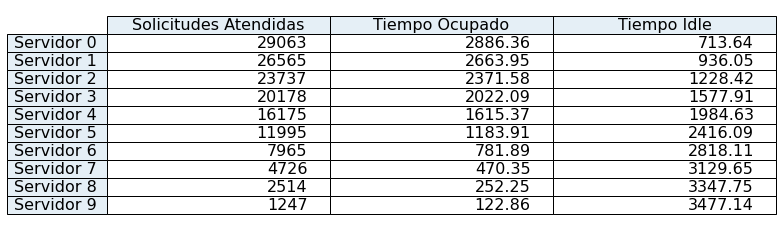

In [74]:
print_server_time_stats(customers_attended_per_server, servers_busy_time)

In [75]:
print_server_queue_stats(q_times, dq_times, finish_time)

### Cantidad de solicitudes: 144165
### Tiempo total procesando: 14391.847231992899
### Tiempo promedio de servicio de solicitud: 0.09982899616406825
### Momento de salida de ultima solicitud: 3600.117
### Total de solicitudes que fueron encoladas: 1257
### Tiempo total de solicitudes en cola: 21.25415374170891
### Tiempo promedio de una solicitud en cola: 0.016908634639386563


## Task 2
Determine empíricamente cuántos servidores se necesitaría "alquilar" en Ants Smart Computing para asegurar que siempre habrá al menos 1 servidor disponible para atender una solicitud dada.

In [76]:
(
    finish_time,
    na, 
    nd, 
    customers_attended_per_server, 
    current_server_state, 
    servers_busy_time,
    tp, 
    arrivals, 
    departures,
    q_times,
    dq_times
) = n_server_simulation(n_servers=30)

Simulation finished...


In [77]:
print(f'Total de solicitudes servidas: {na}')

Total de solicitudes servidas: 144133


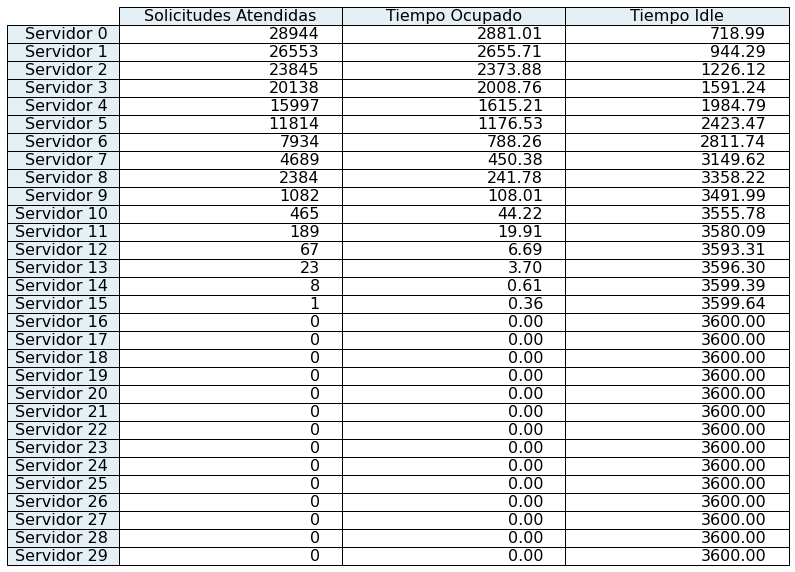

In [78]:
print_server_time_stats(customers_attended_per_server, servers_busy_time)

In [79]:
print_server_queue_stats(q_times, dq_times, finish_time)

### Cantidad de solicitudes: 144133
### Tiempo total procesando: 14375.026882889435
### Tiempo promedio de servicio de solicitud: 0.09973445972046259
### Momento de salida de ultima solicitud: 3600.342
### Total de solicitudes que fueron encoladas: 0
### Tiempo total de solicitudes en cola: 0
### Tiempo promedio de una solicitud en cola: 0


- Para el Task 2, con un máximo de 2,400 solicitudes por minuto, se necesitarían 17 servidores para garantizar que siempre habrá un servidor disponible para atender una solicitud dada.

## Task 3 y 4
Resolver el task 1 y 2 para 6,000 solicitudes por minuto

In [80]:
# amount of servers rented at Ants
SERVERS = 10
# Max requests per minute and second
MAX_REQ_PER_MIN = 6000
MAX_REQ_PER_SEC = MAX_REQ_PER_MIN / 60
# Gorilla computation power, 100 requests per second
GORILLA_REQ_PER_SEC = 100
GORILLA_SEC_PER_REQ = 1 / GORILLA_REQ_PER_SEC
# Ants computation power, 10 requests per second
ANTS_REQ_PER_SEC = 10
ANTS_SEC_PER_REQ = 1 / ANTS_REQ_PER_SEC

# simulation time
T = 3600

#### 1 Servidor (GORILLA)

In [81]:
(t, na, nd, arrivals, departures, ytot) = g_server_simulation()

Simulation finished...


In [82]:
# Some calcs to display results later
busy = sum(ytot)/3600
idle = 3600-sum(ytot)

if idle < 0:
    idle = 0

diff = min(len(arrivals), len(departures))


dep = list(departures.values())
arri = list(arrivals.values())

times = [(dep[i]-arri[i]) for i in range(diff)]
avgTime = sum(times)/diff

avgProcs = len(departures)/3600

In [83]:
print("""
------------------------------------------------------------------
                     ANALISIS DE RESULTADOS
------------------------------------------------------------------
""")
print("Momento de la ultima salida: " + str(list(departures.values())[-1]))
print("Numero de procesos atendidos: " + str(nd))
print("Tiempo procesando: " + str(busy))
print("Tiempo idle: " + str(idle))
print("Tiempo total de los procesos en cola: " + str(sum(ytot)))
print("Tiempo promedio de un proceso en cola: " + str(avgTime))
print("Numero promedio de procesos en cola: " + str(avgProcs))


------------------------------------------------------------------
                     ANALISIS DE RESULTADOS
------------------------------------------------------------------

Momento de la ultima salida: 3616.0541854347352
Numero de procesos atendidos: 360860
Tiempo procesando: 3.0143740609521354
Tiempo idle: 0
Tiempo total de los procesos en cola: 10851.746619427688
Tiempo promedio de un proceso en cola: 8.553948617953589
Numero promedio de procesos en cola: 100.2388888888889


#### N Servidores

In [84]:
(
    finish_time,
    na, 
    nd, 
    customers_attended_per_server, 
    current_server_state, 
    servers_busy_time,
    tp, 
    arrivals, 
    departures,
    q_times,
    dq_times
) = n_server_simulation(n_servers=10)

Simulation finished...


In [85]:
print(f'Total de solicitudes servidas: {na}')

Total de solicitudes servidas: 359404


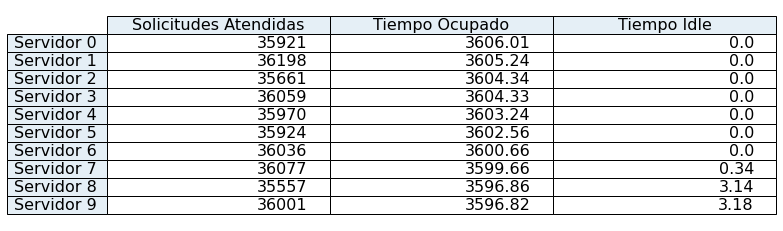

In [86]:
print_server_time_stats(customers_attended_per_server, servers_busy_time)

In [87]:
print_server_queue_stats(q_times, dq_times, finish_time)

### Cantidad de solicitudes: 359404
### Tiempo total procesando: 3613524.232082199
### Tiempo promedio de servicio de solicitud: 10.054212618897393
### Momento de salida de ultima solicitud: 3608.830
### Total de solicitudes que fueron encoladas: 357245
### Tiempo total de solicitudes en cola: 3577504.5154279643
### Tiempo promedio de una solicitud en cola: 10.014148596699643


In [88]:
(
    finish_time,
    na, 
    nd, 
    customers_attended_per_server, 
    current_server_state, 
    servers_busy_time,
    tp, 
    arrivals, 
    departures,
    q_times,
    dq_times
) = n_server_simulation(n_servers=30)

Simulation finished...


In [89]:
print(f'Total de solicitudes servidas: {na}')

Total de solicitudes servidas: 359746


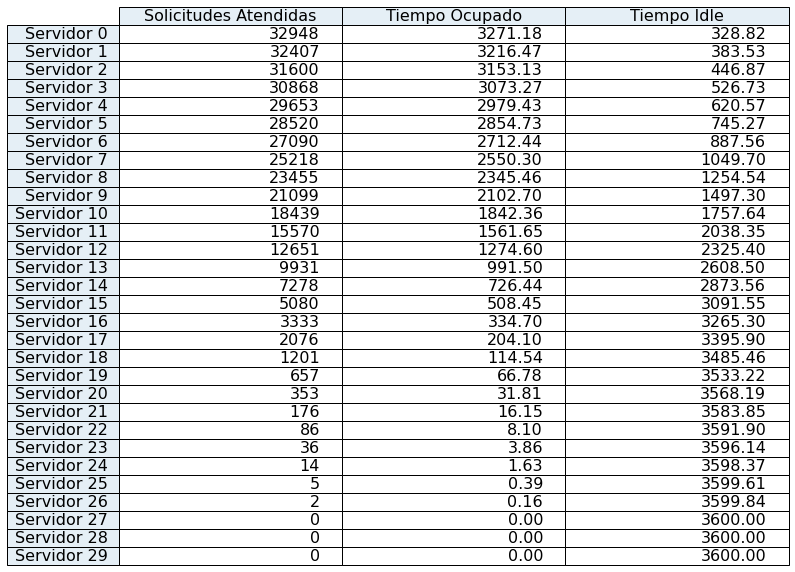

In [90]:
print_server_time_stats(customers_attended_per_server, servers_busy_time)

In [91]:
print_server_queue_stats(q_times, dq_times, finish_time)

### Cantidad de solicitudes: 359746
### Tiempo total procesando: 35946.30974622006
### Tiempo promedio de servicio de solicitud: 0.09992136047717017
### Momento de salida de ultima solicitud: 3600.227
### Total de solicitudes que fueron encoladas: 0
### Tiempo total de solicitudes en cola: 0
### Tiempo promedio de una solicitud en cola: 0


- Para el Task 2, ahora con un máximo de 6,000 solicitudes por minuto, se necesitarían 29 servidores para garantizar que siempre habrá un servidor disponible para atender una solicitud dada.

## Task 5
Emita una recomendación a la junta directiva.

- Dependiendo del presupuesto con el que se cuente, ambas alternativas son viables.
- Si se tiene de un mayor presupuesto, Ants sería la mejor alternativa de las dos. Al poder rentar 29 servidores como se discutió anteriormente para poder atender cualquier solicitud dada sin ningun problema, el cliente no tendría que quedarse esperando en ningún momento. Es una alternativa costosa, pero si se busca el mejor rendimiento, es la mejor opción de las dos.
- Si se tiene un menor presupuesto, Gorilla sería la mejor alternativa de las dos. Al solo mantener un servidor individual, Gorilla es una alternativa económica, pero se estaría sacrificando rendimiento por un precio bajo. Al solo ser un servidor, Gorilla tiene que invertir tiempo en mantener las solicitudes de los clientes en cola, lo cual podría ser algo tedioso para el cliente, tener que esperar alrededor de 8 segundos para que su solicitud sea procesada de otras 6000 solicitudes.
- En conclusión, la recomendación depende del presupuesto. Si se busca una alternativa económica, se utiliza el server Gorilla, y si se cuenta de bastantes recursos, se utiliza Ants Smart Computing para poder procesar todas las solicitudes sin tiempo de cola.